
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fblaura/FraudD/blob/main/2_AutoML/3_AutoML_for_dataset_passed_through_Normalization_and_SMOTE_imbalance_of_0_05.ipynb)

 **Please make sure to install the following libraries in order for the entire notebook to work.**

AutoML H20 is a process that assists in the selection of training models, which compares the performance of models by comparing metrics, which are then reflected in a leaderboard. In order to get an initial idea of which supervised or unsupervised models are ideal for our case (fraud detection) this type of training is used. The data used for this exercise is coded, preprocessed and passed through a technique to adjust the unequal distribution of the classes of the dataset, this technique is called SMOTE (Synthetic Minority Over-sampling Technique), as a rate to adjust the imbalance is chosen: **0.05**. Inside the folder you will find AutoML executions for different scaling methods and SMOTE rates. 


# **1. Libraries Installation**

In [ ]:
! pip install requests
! pip install tabulate
! pip install "colorama>=0.3.8"
! pip install future

In [ ]:
!pip install gdown

In [ ]:
! pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o


Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 175.8 MB 31 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=8e2d4fa8c4b481face26486276ef6f6c2e15dea3888650feb7be519f5099335e
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from pandas_profiling import ProfileReport
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Normalizer, StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV   #Additional scklearn functions
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix, roc_curve,precision_score,roc_auc_score

In [3]:
from google.colab import files

# **2. h2o initialization**

In [ ]:
import h2o
from h2o.automl import H2OAutoML


In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0w1f12l2
  JVM stdout: /tmp/tmp0w1f12l2/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0w1f12l2/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_39wojh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# **3. Dataset initialization**

Due to the size of the dataset it is not possible to download the file from Github, as an alternative a link is used to download the dataset from Drive. ***Remember that this dataset is no longer a representation of the raw data due to its previous preprocessing.*** 

In [4]:
#train_fill
!gdown --id 1hF1FH8e-fQ13ZkDTzFejw04vi1lbDzCu

Downloading...
From: https://drive.google.com/uc?id=1hF1FH8e-fQ13ZkDTzFejw04vi1lbDzCu
To: /content/X_trainn_005.csv
100% 404M/404M [00:03<00:00, 122MB/s]


In [5]:
X_trainn_005 = pd.read_csv('/content/X_trainn_005.csv')

In [6]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

We can observe that the distribution of classes within the dataset being worked on is quite unbiased. We have that for the class representing the existence of 'No fraud' there is a presence of 95.2% of cases, while for the positive event 'Fraud' there are only 4.76% cases. This distribution of data is given after applying the SMOTE imbalance technique with a rate of 0.05.

In [7]:
counting=X_trainn_005['isFraud'].value_counts().values
pieplot=pd.DataFrame([[counting[0], 'NoFraud'], [counting[1], 'Fraud']],columns=['Count of cases', 'Events'])

In [8]:
fig = px.pie(pieplot, values='Count of cases', names='Events', title='Distribution of imbalanced classes')
fig.show()

# **4. AutoML para dataset con escalamiento Normalizado e imbalanceo con SMOTE 0.05 y métrica de clasif.**

The training process with AutoML is then initiated, the task is defined as a classification problem. The conversion from Pandas Dataframe to H2O dataframe is made in order to start the automatic process; the leaderboard and the best models are called. 

Different notebooks are created due to the RAM consumption generated by the conversion from Pandas to H20 driven by the volume of the dataset. Recall also that the original Kaggle competition dataset has approximately 590.000 rows, while this notebook works with a partition representing one eighth of the data. 

In [ ]:
hftrainn_005 = h2o.H2OFrame(X_trainn_005)
#hftest =h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
trainn_005, testnn_005 = hftrainn_005.split_frame(ratios=[.7]) #mirar en diferentes proporciones 70/30 ... 

In [ ]:
xnn_005 = trainn_005.columns
ynn_005 = "isFraud"
xnn_005.remove(ynn_005)

In [ ]:
trainn_005[ynn_005] = trainn_005[ynn_005].asfactor()


Run AutoML for 15 base models

In [ ]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs = 3600*5, max_models=15, seed=1) # tres horas, ir modificando el tiempo, trabajar con 10 modelos 
# ir mirando si se necesita aumentar más modelos
aml.train(x=xnn_005, y=ynn_005, training_frame=trainn_005)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_6_AutoML_1_20211010_165737,0.968485,0.0503413,0.887469,0.107311,0.106153,0.0112684
StackedEnsemble_AllModels_1_AutoML_1_20211010_165737,0.968369,0.0502787,0.887204,0.103485,0.106047,0.0112459
StackedEnsemble_AllModels_3_AutoML_1_20211010_165737,0.96821,0.0501955,0.887438,0.104159,0.105903,0.0112154
StackedEnsemble_AllModels_2_AutoML_1_20211010_165737,0.968054,0.0503565,0.887003,0.109284,0.106081,0.0112532
StackedEnsemble_BestOfFamily_6_AutoML_1_20211010_165737,0.967852,0.0513192,0.885087,0.109163,0.107402,0.0115352
StackedEnsemble_BestOfFamily_3_AutoML_1_20211010_165737,0.967766,0.0513197,0.884888,0.111962,0.107333,0.0115204
StackedEnsemble_AllModels_5_AutoML_1_20211010_165737,0.967631,0.0498771,0.888971,0.109193,0.105398,0.0111087
StackedEnsemble_BestOfFamily_1_AutoML_1_20211010_165737,0.967547,0.0512017,0.885569,0.103092,0.107029,0.0114551
StackedEnsemble_BestOfFamily_2_AutoML_1_20211010_165737,0.96751,0.0512094,0.885492,0.104029,0.107081,0.0114663
GBM_1_AutoML_1_20211010_165737,0.966935,0.0546641,0.883247,0.115073,0.111017,0.0123247


With the use of `extra_columns` is possible to obtain de timen information regarding each trained model



In [ ]:
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_6_AutoML_1_20211010_165737,0.968485,0.0503413,0.887469,0.107311,0.106153,0.0112684,117828,0.336286,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211010_165737,0.968369,0.0502787,0.887204,0.103485,0.106047,0.0112459,12195,0.210624,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211010_165737,0.96821,0.0501955,0.887438,0.104159,0.105903,0.0112154,15140,0.222781,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211010_165737,0.968054,0.0503565,0.887003,0.109284,0.106081,0.0112532,13186,0.225441,StackedEnsemble
StackedEnsemble_BestOfFamily_6_AutoML_1_20211010_165737,0.967852,0.0513192,0.885087,0.109163,0.107402,0.0115352,110499,0.080242,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211010_165737,0.967766,0.0513197,0.884888,0.111962,0.107333,0.0115204,15195,0.082534,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_1_20211010_165737,0.967631,0.0498771,0.888971,0.109193,0.105398,0.0111087,58340,0.461124,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20211010_165737,0.967547,0.0512017,0.885569,0.103092,0.107029,0.0114551,10801,0.083122,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211010_165737,0.96751,0.0512094,0.885492,0.104029,0.107081,0.0114663,10668,0.11274,StackedEnsemble
GBM_1_AutoML_1_20211010_165737,0.966935,0.0546641,0.883247,0.115073,0.111017,0.0123247,572577,0.067925,GBM


And as well we can obtain information about the leader model

In [ ]:
# Get the best model using the metric
m = aml.leader
m

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_6_AutoML_1_20211010_165737

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0011566998459864224
RMSE: 0.034010290295532944
LogLoss: 0.010769936773739254
Null degrees of freedom: 9949
Residual degrees of freedom: 9943
Null deviance: 3786.9168811794634
Residual deviance: 214.32174179741114
AIC: 228.32174179741114
AUC: 0.9999547760122094
AUCPR: 0.9992850251342118
Gini: 0.9999095520244188

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2735790370095935: 


,,0,1,Error,Rate
0,0,9480.0,0.0,0.0,(0.0/9480.0)
1,1,3.0,467.0,0.0064,(3.0/470.0)
2,Total,9483.0,467.0,0.0003,(3.0/9950.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273579,0.996798,132.0
1,max f2,0.273579,0.994887,132.0
2,max f0point5,0.273579,0.998717,132.0
3,max accuracy,0.273579,0.999698,132.0
4,max precision,0.999900,1.000000,0.0
5,max recall,0.064527,1.000000,209.0
6,max specificity,0.999900,1.000000,0.0
7,max absolute_mcc,0.273579,0.996646,132.0
8,max min_per_class_accuracy,0.123061,0.996308,163.0
9,max mean_per_class_accuracy,0.224238,0.997609,138.0



Gains/Lift Table: Avg response rate:  4.72 %, avg score:  5.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01005,0.999145,21.170213,21.170213,1.000000,0.999607,1.000000,0.999607,0.212766,0.212766,2017.021277,2017.021277,0.212766
1,2,0.02000,0.996640,21.170213,21.170213,1.000000,0.998141,1.000000,0.998878,0.210638,0.423404,2017.021277,2017.021277,0.423404
2,3,0.03005,0.986388,21.170213,21.170213,1.000000,0.992693,1.000000,0.996809,0.212766,0.636170,2017.021277,2017.021277,0.636170
3,4,0.04000,0.924862,21.170213,21.170213,1.000000,0.968364,1.000000,0.989734,0.210638,0.846809,2017.021277,2017.021277,0.846809
4,5,0.05005,0.130724,14.819149,19.894899,0.700000,0.578405,0.939759,0.907138,0.148936,0.995745,1381.914894,1889.489874,0.992580
5,6,0.10000,0.027562,0.085192,10.000000,0.004024,0.052929,0.472362,0.480463,0.004255,1.000000,-91.480800,900.000000,0.944620
6,7,0.15005,0.015900,0.000000,6.664434,0.000000,0.020489,0.314802,0.327036,0.000000,1.000000,-100.000000,566.443403,0.892089
7,8,0.20000,0.011398,0.000000,5.000000,0.000000,0.013542,0.236181,0.248741,0.000000,1.000000,-100.000000,400.000000,0.839662
8,9,0.30000,0.006616,0.000000,3.333333,0.000000,0.008613,0.157454,0.168698,0.000000,1.000000,-100.000000,233.333333,0.734705
9,10,0.40000,0.004448,0.000000,2.500000,0.000000,0.005427,0.118090,0.127880,0.000000,1.000000,-100.000000,150.000000,0.629747




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.011268433272609527
RMSE: 0.10615287689276032
LogLoss: 0.050341274143009186
Null degrees of freedom: 52115
Residual degrees of freedom: 52108
Null deviance: 19964.014856908463
Residual deviance: 5247.171686474134
AIC: 5263.171686474134
AUC: 0.9684851368042641
AUCPR: 0.8874688476339909
Gini: 0.9369702736085281

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37060908093003314: 


,,0,1,Error,Rate
0,0,49475.0,158.0,0.0032,(158.0/49633.0)
1,1,525.0,1958.0,0.2114,(525.0/2483.0)
2,Total,50000.0,2116.0,0.0131,(683.0/52116.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.370609,0.851489,163.0
1,max f2,0.159792,0.831412,228.0
2,max f0point5,0.710775,0.912579,89.0
3,max accuracy,0.370609,0.986895,163.0
4,max precision,0.999724,1.000000,0.0
5,max recall,0.000303,1.000000,399.0
6,max specificity,0.999724,1.000000,0.0
7,max absolute_mcc,0.370609,0.847637,163.0
8,max min_per_class_accuracy,0.028418,0.918965,323.0
9,max mean_per_class_accuracy,0.065514,0.924377,282.0



Gains/Lift Table: Avg response rate:  4.76 %, avg score:  4.76 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010016,0.998406,20.989126,20.989126,1.000000,0.999380,1.000000,0.999380,0.210230,0.210230,1998.912606,1998.912606,0.210230
1,2,0.020013,0.990275,20.948840,20.969002,0.998081,0.995667,0.999041,0.997525,0.209424,0.419654,1994.883983,1996.900225,0.419633
2,3,0.030010,0.897773,20.626550,20.854924,0.982726,0.962228,0.993606,0.985767,0.206202,0.625856,1962.654998,1985.492448,0.625654
3,4,0.040007,0.397050,15.469912,19.509317,0.737044,0.669358,0.929496,0.906703,0.154652,0.780507,1446.991249,1850.931717,0.777546
4,5,0.050004,0.166050,5.881790,16.784858,0.280230,0.253845,0.799693,0.776181,0.058800,0.839307,488.178964,1578.485752,0.828790
5,6,0.100008,0.037846,1.304773,9.044815,0.062164,0.074899,0.430929,0.425540,0.065244,0.904551,30.477299,804.481526,0.844792
6,7,0.150012,0.020462,0.555737,6.215122,0.026477,0.027480,0.296112,0.292853,0.027789,0.932340,-44.426335,521.512239,0.821466
7,8,0.200015,0.013404,0.233570,4.719734,0.011128,0.016473,0.224866,0.223758,0.011679,0.944019,-76.642953,371.973441,0.781224
8,9,0.300004,0.007691,0.169170,3.203074,0.008060,0.010099,0.152606,0.152547,0.016915,0.960934,-83.083030,220.307354,0.693995
9,10,0.400012,0.005016,0.092623,2.425424,0.004413,0.006209,0.115556,0.115961,0.009263,0.970197,-90.737723,142.542355,0.598711


And for other models that may be of interest to us

In [ ]:
# Get the best XGBoost model using default sort metric
xgb = aml.get_best_model(algorithm="xgboost")
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_1_20211010_165737


Model Summary: 


,,number_of_trees
0,,99.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.0072926305264888235
RMSE: 0.08539689998172546
LogLoss: 0.03255415011577529
Mean Per-Class Error: 0.03557765630821652
AUC: 0.992924436690317
AUCPR: 0.9602219626941793
Gini: 0.9858488733806341

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23697705566883087: 


,,0,1,Error,Rate
0,0,49528.0,105.0,0.0021,(105.0/49633.0)
1,1,275.0,2208.0,0.1108,(275.0/2483.0)
2,Total,49803.0,2313.0,0.0073,(380.0/52116.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.236977,0.920767,200.0
1,max f2,0.156499,0.913785,228.0
2,max f0point5,0.412316,0.956669,162.0
3,max accuracy,0.287666,0.992824,186.0
4,max precision,0.999675,1.000000,0.0
5,max recall,0.001095,1.000000,393.0
6,max specificity,0.999675,1.000000,0.0
7,max absolute_mcc,0.287666,0.918355,186.0
8,max min_per_class_accuracy,0.053852,0.961337,289.0
9,max mean_per_class_accuracy,0.078952,0.964422,269.0



Gains/Lift Table: Avg response rate:  4.76 %, avg score:  4.77 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010016,0.995510,20.989126,20.989126,1.000000,0.998442,1.000000,0.998442,0.210230,0.210230,1998.912606,1998.912606,0.210230
1,2,0.020013,0.969408,20.989126,20.989126,1.000000,0.985907,1.000000,0.992180,0.209827,0.420056,1998.912606,1998.912606,0.420056
2,3,0.030010,0.858439,20.989126,20.989126,1.000000,0.925978,1.000000,0.970127,0.209827,0.629883,1998.912606,1998.912606,0.629883
3,4,0.040007,0.434346,20.344546,20.828058,0.969290,0.693487,0.992326,0.901000,0.203383,0.833266,1934.454637,1982.805842,0.832944
4,5,0.050004,0.147286,8.903257,18.444013,0.424184,0.245041,0.878741,0.769859,0.089005,0.922271,790.325693,1744.401330,0.915905
5,6,0.100008,0.039814,0.958444,9.701229,0.045664,0.069930,0.462203,0.419895,0.047926,0.970197,-4.155564,870.122883,0.913723
6,7,0.150012,0.022841,0.241625,6.548027,0.011512,0.029717,0.311972,0.289835,0.012082,0.982280,-75.837537,554.802743,0.873904
7,8,0.200015,0.015910,0.120812,4.941224,0.005756,0.019056,0.235418,0.222141,0.006041,0.988321,-87.918769,394.122365,0.827742
8,9,0.300004,0.009102,0.060418,3.314496,0.002879,0.012052,0.157915,0.152120,0.006041,0.994362,-93.958225,231.449647,0.729095
9,10,0.400012,0.005848,0.012081,2.488853,0.000576,0.007305,0.118578,0.115914,0.001208,0.995570,-98.791877,148.885305,0.625352




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.014181520632763085
RMSE: 0.11908618993301903
LogLoss: 0.062222734306570056
Mean Per-Class Error: 0.09264259024915855
AUC: 0.9573478109022197
AUCPR: 0.8498670304363815
Gini: 0.9146956218044393

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3462326228618622: 


,,0,1,Error,Rate
0,0,49463.0,170.0,0.0034,(170.0/49633.0)
1,1,682.0,1801.0,0.2747,(682.0/2483.0)
2,Total,50145.0,1971.0,0.0163,(852.0/52116.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.346233,0.808711,169.0
1,max f2,0.166659,0.792409,223.0
2,max f0point5,0.510570,0.884010,134.0
3,max accuracy,0.436342,0.983671,148.0
4,max precision,0.999685,1.000000,0.0
5,max recall,0.000068,1.000000,399.0
6,max specificity,0.999685,1.000000,0.0
7,max absolute_mcc,0.346233,0.806117,169.0
8,max min_per_class_accuracy,0.028354,0.900524,323.0
9,max mean_per_class_accuracy,0.055635,0.907357,291.0



Gains/Lift Table: Avg response rate:  4.76 %, avg score:  4.48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010016,0.994046,20.989126,20.989126,1.000000,0.998008,1.000000,0.998008,0.210230,0.210230,1998.912606,1998.912606,0.210230
1,2,0.020013,0.951040,20.868267,20.928755,0.994242,0.978722,0.997124,0.988374,0.208619,0.418848,1986.826737,1992.875465,0.418788
2,3,0.030010,0.702936,19.699967,20.519421,0.938580,0.860935,0.977621,0.945922,0.196939,0.615787,1869.996668,1951.942055,0.615082
3,4,0.040007,0.288815,12.811021,18.593245,0.610365,0.473549,0.885851,0.827885,0.128071,0.743858,1181.102128,1759.324500,0.739063
4,5,0.050004,0.153739,5.438641,15.963334,0.259117,0.211209,0.760553,0.704597,0.054370,0.798228,443.864111,1496.333379,0.785656
5,6,0.100008,0.043389,1.498073,8.730703,0.071374,0.076941,0.415963,0.390769,0.074909,0.873137,49.807270,773.070324,0.811807
6,7,0.150012,0.024518,0.676549,6.045985,0.032233,0.032250,0.288053,0.271263,0.033830,0.906967,-32.345104,504.598515,0.794824
7,8,0.200015,0.016233,0.346329,4.621071,0.016500,0.019899,0.220165,0.208422,0.017318,0.924285,-65.367137,362.107102,0.760503
8,9,0.300004,0.009076,0.221532,3.154746,0.010555,0.012114,0.150304,0.142994,0.022151,0.946436,-77.846825,215.474552,0.678771
9,10,0.400012,0.005703,0.153029,2.404280,0.007291,0.007225,0.114549,0.109050,0.015304,0.961740,-84.697107,140.428038,0.589830




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.983575,0.001951,0.985706,0.980716,0.982635,0.984745,0.984074
1,auc,0.958239,0.004056,0.961480,0.953353,0.959297,0.962412,0.954651
2,err,0.016425,0.001951,0.014294,0.019284,0.017365,0.015255,0.015926
3,err_count,171.200000,20.327322,149.000000,201.000000,181.000000,159.000000,166.000000
4,f0point5,0.858558,0.019819,0.881168,0.845389,0.831524,0.866667,0.868040
5,f1,0.812724,0.015474,0.824499,0.788198,0.808870,0.815331,0.826722
6,f2,0.771850,0.020512,0.774679,0.738255,0.787418,0.769737,0.789159
7,lift_top_group,21.034460,1.089814,22.178724,19.740530,21.056566,22.035940,20.160542
8,logloss,0.062223,0.006557,0.057328,0.073297,0.060871,0.057369,0.062249
9,max_per_class_error,0.253044,0.025490,0.255319,0.291667,0.226263,0.257928,0.234043



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-10 20:58:50,9 min 30.597 sec,0.0,0.500000,0.693147,0.500000,0.047644,1.000000,0.952356
1,,2021-10-10 20:58:58,9 min 38.481 sec,5.0,0.184095,0.176330,0.885979,0.682494,20.948917,0.025232
2,,2021-10-10 20:59:03,9 min 43.658 sec,10.0,0.145200,0.100750,0.926576,0.760883,20.948917,0.021184
3,,2021-10-10 20:59:09,9 min 49.170 sec,15.0,0.135072,0.080801,0.949078,0.804081,20.989126,0.018708
4,,2021-10-10 20:59:15,9 min 54.702 sec,20.0,0.129049,0.072037,0.958442,0.827624,20.989126,0.018133
5,,2021-10-10 20:59:20,10 min 0.606 sec,25.0,0.123947,0.066134,0.964277,0.848333,20.989126,0.016406
6,,2021-10-10 20:59:26,10 min 6.145 sec,30.0,0.119237,0.061453,0.968352,0.864526,20.989126,0.015331
7,,2021-10-10 20:59:32,10 min 11.749 sec,35.0,0.115423,0.057971,0.971864,0.876638,20.989126,0.013930
8,,2021-10-10 20:59:37,10 min 17.229 sec,40.0,0.111925,0.054619,0.975831,0.889178,20.989126,0.013029
9,,2021-10-10 20:59:43,10 min 22.963 sec,45.0,0.109426,0.052256,0.977878,0.896631,20.989126,0.012530



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,V294,1151.531860,1.000000,0.046408
1,M5,1130.483398,0.981721,0.045560
2,V189,890.223938,0.773078,0.035877
3,V317,816.695557,0.709225,0.032914
4,card6,798.972595,0.693835,0.032200
5,C12,640.230896,0.555982,0.025802
6,C14,596.522522,0.518025,0.024041
7,C11,563.521362,0.489367,0.022711
8,V245,531.824158,0.461841,0.021433
9,C13,460.614899,0.400002,0.018563



See the whole table with table.as_data_frame()


We can also generate a printout of the specific parameters of a certain model. Based on this information we can define some arguments of our classification model, in this case, with supervised classification methods. 

In [ ]:
xgradboost=xgb.params.keys()
for keys in xgradboost:
  print(keys,xgb.params[keys])

model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'XGBoost_3_AutoML_1_20211010_165737', 'type': 'Key<Model>', 'URL': '/3/Models/XGBoost_3_AutoML_1_20211010_165737'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_165737_training_py_4_sid_bca4', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_165737_training_py_4_sid_bca4'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_165737_training_py_4_sid_bca4', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_165737_training_py_4_sid_bca4'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': False, 'input': False}
kee

In [ ]:
gbm = aml.get_best_model(algorithm="GBM")
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_1_20211010_165737


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,182.0,182.0,267297.0,15.0,15.0,15.0,24.0,241.0,111.39011




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0015137352073698869
RMSE: 0.03890675015173957
LogLoss: 0.009317816580759747
Mean Per-Class Error: 0.0013997303234334346
AUC: 0.9999726506451838
AUCPR: 0.9995937573386696
Gini: 0.9999453012903676

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17836328416659403: 


,,0,1,Error,Rate
0,0,49627.0,6.0,0.0001,(6.0/49633.0)
1,1,12.0,2471.0,0.0048,(12.0/2483.0)
2,Total,49639.0,2477.0,0.0003,(18.0/52116.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.178363,0.996371,232.0
1,max f2,0.137705,0.996058,241.0
2,max f0point5,0.204691,0.997494,229.0
3,max accuracy,0.197305,0.999655,230.0
4,max precision,0.999817,1.000000,0.0
5,max recall,0.024737,1.000000,311.0
6,max specificity,0.999817,1.000000,0.0
7,max absolute_mcc,0.178363,0.996190,232.0
8,max min_per_class_accuracy,0.115660,0.997986,247.0
9,max mean_per_class_accuracy,0.115660,0.998600,247.0



Gains/Lift Table: Avg response rate:  4.76 %, avg score:  4.75 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010016,0.997112,20.989126,20.989126,1.000000,0.998847,1.000000,0.998847,0.210230,0.210230,1998.912606,1998.912606,0.210230
1,2,0.020013,0.988791,20.989126,20.989126,1.000000,0.993688,1.000000,0.996270,0.209827,0.420056,1998.912606,1998.912606,0.420056
2,3,0.030010,0.956735,20.989126,20.989126,1.000000,0.975345,1.000000,0.989300,0.209827,0.629883,1998.912606,1998.912606,0.629883
3,4,0.040007,0.839201,20.989126,20.989126,1.000000,0.913918,1.000000,0.970463,0.209827,0.839710,1998.912606,1998.912606,0.839710
4,5,0.050004,0.077796,15.832489,19.958194,0.754319,0.508380,0.950883,0.878082,0.158276,0.997986,1483.248856,1895.819431,0.995407
5,6,0.100008,0.015002,0.040271,9.999233,0.001919,0.029040,0.476401,0.453561,0.002014,1.000000,-95.972923,899.923254,0.945016
6,7,0.150012,0.008605,0.000000,6.666155,0.000000,0.011222,0.317600,0.306115,0.000000,1.000000,-100.000000,566.615503,0.892511
7,8,0.200015,0.005909,0.000000,4.999616,0.000000,0.007075,0.238200,0.231355,0.000000,1.000000,-100.000000,399.961627,0.840006
8,9,0.300004,0.003408,0.000000,3.333291,0.000000,0.004469,0.158810,0.155736,0.000000,1.000000,-100.000000,233.329069,0.735015
9,10,0.400012,0.002228,0.000000,2.499928,0.000000,0.002759,0.119106,0.117490,0.000000,1.000000,-100.000000,149.992805,0.630004




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.012324710465621827
RMSE: 0.11101671255095706
LogLoss: 0.05466414391055319
Mean Per-Class Error: 0.0758874366606429
AUC: 0.9669348694001161
AUCPR: 0.8832468468203964
Gini: 0.9338697388002322

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2696754785403064: 


,,0,1,Error,Rate
0,0,49484.0,149.0,0.003,(149.0/49633.0)
1,1,564.0,1919.0,0.2271,(564.0/2483.0)
2,Total,50048.0,2068.0,0.0137,(713.0/52116.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.269675,0.843331,207.0
1,max f2,0.078829,0.825167,280.0
2,max f0point5,0.530976,0.908996,144.0
3,max accuracy,0.313405,0.986396,197.0
4,max precision,0.999745,1.000000,0.0
5,max recall,0.000128,1.000000,399.0
6,max specificity,0.999745,1.000000,0.0
7,max absolute_mcc,0.313405,0.840246,197.0
8,max min_per_class_accuracy,0.014963,0.913814,345.0
9,max mean_per_class_accuracy,0.030337,0.924113,323.0



Gains/Lift Table: Avg response rate:  4.76 %, avg score:  4.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010016,0.995268,20.989126,20.989126,1.000000,0.998165,1.000000,0.998165,0.210230,0.210230,1998.912606,1998.912606,0.210230
1,2,0.020013,0.968973,20.948840,20.969002,0.998081,0.986707,0.999041,0.992441,0.209424,0.419654,1994.883983,1996.900225,0.419633
2,3,0.030010,0.771376,20.384833,20.774404,0.971209,0.901537,0.989770,0.962159,0.203786,0.623439,1938.483260,1977.440354,0.623117
3,4,0.040007,0.254317,15.147623,19.368383,0.721689,0.501045,0.922782,0.846936,0.151430,0.774869,1414.762264,1836.838299,0.771625
4,5,0.050004,0.101508,5.760931,16.647937,0.274472,0.156829,0.793170,0.708968,0.057592,0.832461,476.093095,1564.793690,0.821601
5,6,0.100008,0.021237,1.393369,9.020653,0.066385,0.042861,0.429777,0.375914,0.069674,0.902135,39.336869,802.065280,0.842255
6,7,0.150012,0.010929,0.467141,6.169482,0.022256,0.015028,0.293937,0.255619,0.023359,0.925493,-53.285905,516.948218,0.814277
7,8,0.200015,0.007016,0.273841,4.695572,0.013047,0.008705,0.223715,0.193891,0.013693,0.939186,-72.615875,369.557195,0.776150
8,9,0.300004,0.003869,0.189309,3.193676,0.009019,0.005175,0.152159,0.130993,0.018929,0.958115,-81.069105,219.367642,0.691035
9,10,0.400012,0.002468,0.128866,2.427437,0.006140,0.003095,0.115652,0.099017,0.012888,0.971003,-87.113353,142.743718,0.599556




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.986492,0.001609,0.988584,0.984074,0.986856,0.986472,0.986472
1,auc,0.966895,0.004338,0.968890,0.964519,0.969920,0.970721,0.960425
2,err,0.013508,0.001609,0.011416,0.015926,0.013144,0.013528,0.013528
3,err_count,140.800000,16.769018,119.000000,166.000000,137.000000,141.000000,141.000000
4,f0point5,0.888661,0.010796,0.900094,0.892193,0.886556,0.871369,0.893090
5,f1,0.847348,0.016113,0.865232,0.822270,0.852846,0.842809,0.853583
6,f2,0.810114,0.027429,0.832970,0.762510,0.821606,0.816062,0.817422
7,lift_top_group,21.034460,1.089814,22.178724,19.740530,21.056566,22.035940,20.160542
8,logloss,0.054820,0.005871,0.048630,0.064101,0.053176,0.051899,0.056297
9,max_per_class_error,0.212763,0.034161,0.187234,0.272727,0.197980,0.200846,0.205029



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-10 18:41:14,47 min 49.039 sec,0.0,0.213011,0.191518,0.500000,0.047644,1.000000,0.952356
1,,2021-10-10 18:41:32,48 min 6.983 sec,5.0,0.177519,0.124692,0.946483,0.698999,20.230964,0.031123
2,,2021-10-10 18:41:47,48 min 21.854 sec,10.0,0.159917,0.103713,0.954765,0.759639,20.627245,0.024657
3,,2021-10-10 18:42:02,48 min 36.645 sec,15.0,0.147067,0.089959,0.959761,0.797413,20.788081,0.021932
4,,2021-10-10 18:42:16,48 min 51.086 sec,20.0,0.138367,0.080995,0.963692,0.822811,20.908708,0.020186
5,,2021-10-10 18:42:31,49 min 5.462 sec,25.0,0.132460,0.074934,0.966066,0.838481,20.989126,0.019130
6,,2021-10-10 18:42:45,49 min 19.778 sec,30.0,0.127611,0.069902,0.969187,0.853771,20.989126,0.017442
7,,2021-10-10 18:42:59,49 min 33.841 sec,35.0,0.123332,0.065653,0.972479,0.867116,20.989126,0.016406
8,,2021-10-10 18:43:15,49 min 49.380 sec,40.0,0.118249,0.060803,0.976042,0.883521,20.989126,0.014640
9,,2021-10-10 18:43:29,50 min 3.763 sec,45.0,0.114303,0.057147,0.978747,0.894871,20.989126,0.013489



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,V245,375.097717,1.000000,0.063971
1,M5,299.854523,0.799404,0.051139
2,V188,284.655273,0.758883,0.048547
3,V189,243.319641,0.648683,0.041497
4,card6,203.907898,0.543613,0.034776
5,V317,144.394150,0.384951,0.024626
6,C7,143.661118,0.382997,0.024501
7,C12,129.979065,0.346521,0.022167
8,C13,110.976799,0.295861,0.018927
9,card2,106.503563,0.283936,0.018164



See the whole table with table.as_data_frame()


In [ ]:
gradientm=gbm.params.keys()
for keys in gradientm:
  print(keys,gbm.params[keys])

model_id {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_1_AutoML_1_20211010_165737', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_1_AutoML_1_20211010_165737'}, 'input': None}
training_frame {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_165737_training_py_4_sid_bca4', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_165737_training_py_4_sid_bca4'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20211010_165737_training_py_4_sid_bca4', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20211010_165737_training_py_4_sid_bca4'}}
validation_frame {'default': None, 'actual': None, 'input': None}
nfolds {'default': 0, 'actual': 5, 'input': 5}
keep_cross_validation_models {'default': True, 'actual': False, 'input': False}
keep_cross_

# **5. XGB**

As it could be observed on the leaderboard, among the models that presented better behavior apart from StackedEnsemble models were GradientBoosting and XGBoost, for this reason the parameters found within the AutoML process will be used to train these models and verify their metrics and correlation matrix. 

In [9]:
Y = X_trainn_005['isFraud'].values
X = X_trainn_005.drop(['isFraud', 'TransactionID'], axis=1)

In [ ]:
#params = {
#        'min_child_weight': [1, 5, 10],
#        'gamma': [0.5, 1, 1.5, 2, 5],
#        'subsample': [0.6, 0.8, 1.0],
#        'colsample_bytree': [0.6, 0.8, 1.0],
#        'max_depth': [3, 4, 5]
#        }

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, random_state=42, stratify=Y)

In [11]:
clf = XGBClassifier(nfolds=5, stopping_metric='log_loss', ntrees=99, max_depth=5, min_rows=3, min_child_weight=3, sample_rate=0.8, subsample=0.8, colsample_bytree=0.8, keep_cross_validation_predictions=True, n_estimators=600, objective='binary:logistic',
                    verbosity=1)
start_time = timer(None) 
clf.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 12 minutes and 39.58 seconds.


In [ ]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=8)

In [ ]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[0.65395641 0.61181927 0.56093216 0.58884954 0.56571722 0.57893229
 0.58015943 0.58450341]
[665.34394193 662.79387426 662.39068818 661.82258344 660.90303087
 662.6419518  670.03485775 677.41941667]
[98.48419848419849, 98.45559845559846, 98.4126984126984, 98.71299871299871, 98.56999856999857, 98.45559845559846, 98.5985985985986, 98.7987987987988]
[98.48419848419849, 98.45559845559846, 98.4126984126984, 98.71299871299871, 98.56999856999857, 98.45559845559846, 98.5985985985986, 98.7987987987988]
[96.24205286367447, 97.8390327264201, 94.8688778868959, 96.71356040725412, 97.08582456330204, 96.33647160674187, 96.58239320401482, 97.15526337147958]


Text(68.625, 0.5, '%')

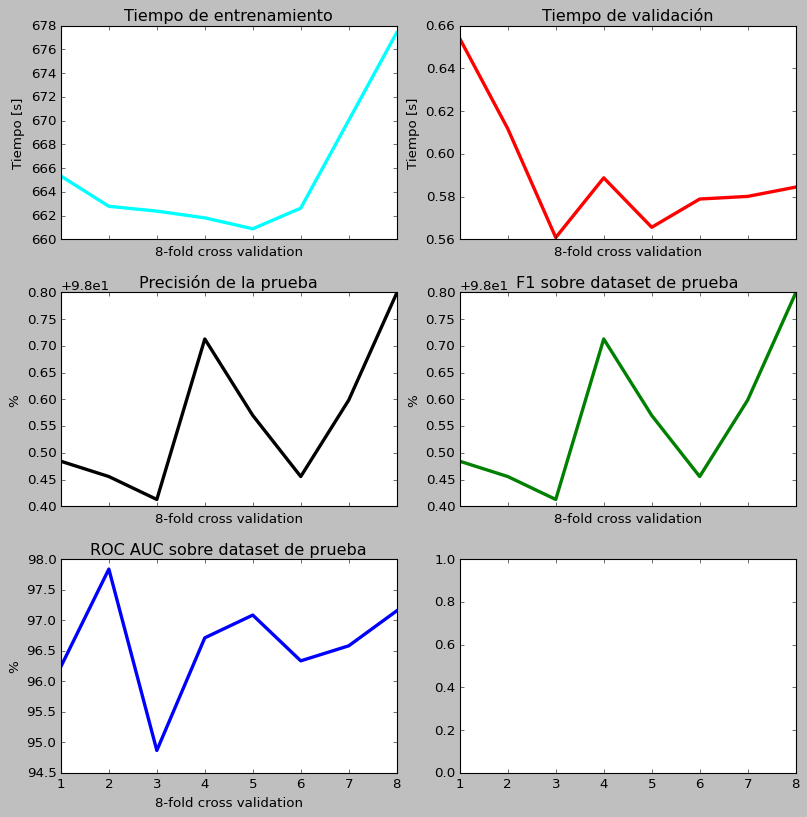

In [ ]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

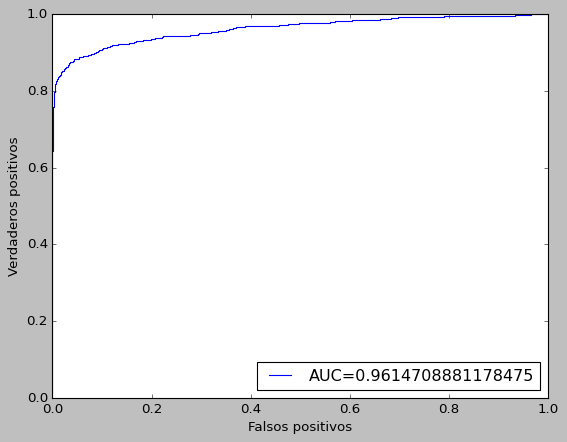

In [ ]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

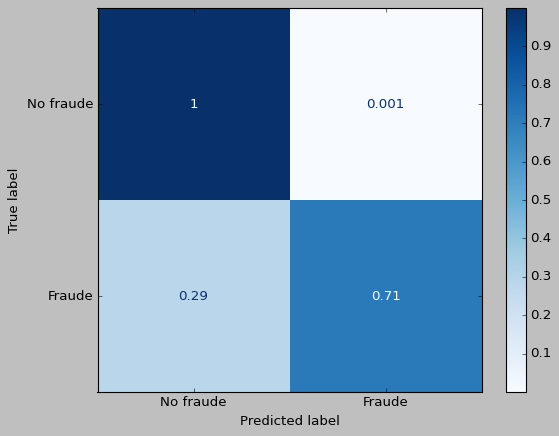

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

In [13]:
import pickle

In [14]:
# save model to file
pickle.dump(clf, open("xgb_n005.pickle.dat", "wb"))

# **6. GBM**

In [12]:
model1 = GradientBoostingClassifier(n_estimators=700,  max_depth=15, max_features='sqrt')
start_time = timer(None) 
model1.fit(X_train,y_train)
timer(start_time)


 Time taken: 0 hours 4 minutes and 42.28 seconds.


In [ ]:
scoring = ['roc_auc', 'accuracy','f1_micro']

scores2 = cross_validate(model1, X_train, y_train, scoring=scoring, cv=8)

In [ ]:
cv=range(1,9)
fit_time=scores2['fit_time']
score_time=scores2['score_time']
test_accuracy=[k*100 for k in scores2['test_accuracy']]
test_f1_micro=[k*100 for k in scores2['test_f1_micro']]
test_roc_auc=[k*100 for k in scores2['test_roc_auc']]
print(score_time)
print(fit_time)
print(test_accuracy)
print(test_f1_micro)
print(test_roc_auc)

[0.64241099 0.7493577  0.75650525 0.66980386 0.7322886  0.67435861
 1.43478179 0.72695422]
[254.40767813 252.8710804  244.17687583 262.56210589 243.28303361
 256.97433066 268.61418915 252.43559933]
[98.02659802659802, 97.82639782639782, 98.02659802659802, 98.12669812669813, 97.91219791219791, 98.06949806949807, 98.09809809809809, 98.2982982982983]
[98.02659802659802, 97.82639782639782, 98.02659802659802, 98.12669812669813, 97.91219791219791, 98.06949806949807, 98.09809809809809, 98.2982982982983]
[95.56403250096945, 96.77276375474574, 94.33171910649388, 95.67387207026847, 97.09817926034142, 95.99044990936883, 96.16896175454734, 96.68276384492603]


Text(68.625, 0.5, '%')

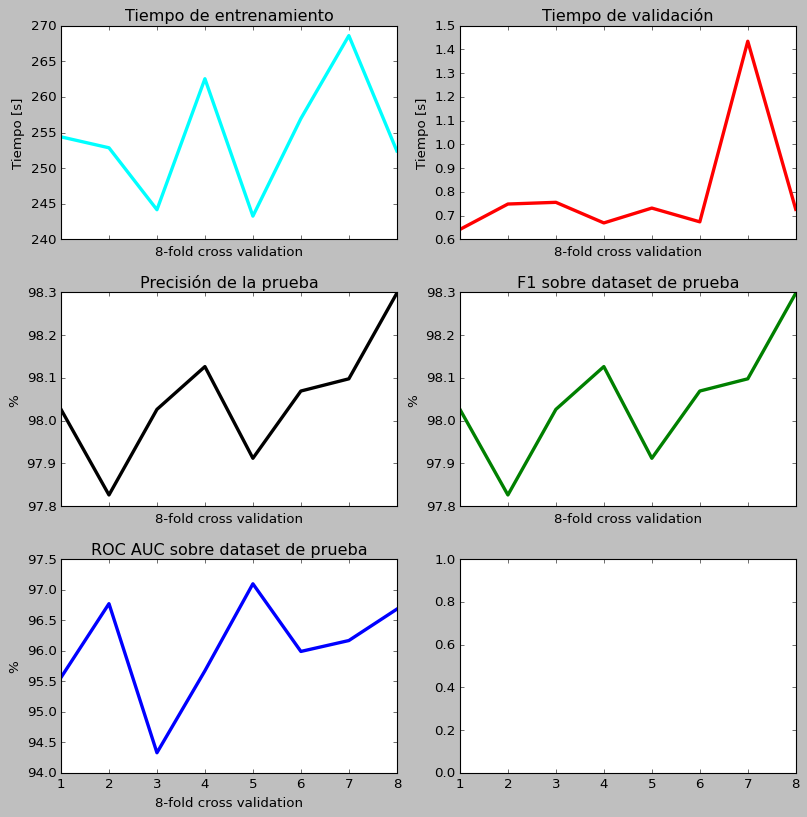

In [ ]:
plt.style.use('classic')
# Create subplots
fig, ax = plt.subplots(3, 2,figsize=(10,10), sharex=True)
fig.tight_layout(h_pad=3, w_pad=2)

ax[0][0].plot(cv,fit_time, linewidth=3, color='cyan')
ax[0][1].plot(cv,score_time, linewidth=3, color='red')
ax[1][0].plot(cv,test_accuracy, linewidth=3, color='black')
ax[1][1].plot(cv,test_f1_micro,linewidth=3, color='green')
ax[2][0].plot(cv,test_roc_auc,linewidth=3, color='blue')
#------1
ax[0][0].title.set_text('Tiempo de entrenamiento')
ax[0][0].set_xlabel('8-fold cross validation')
ax[0][0].set_ylabel('Tiempo [s]')
#------2
ax[0][1].title.set_text('Tiempo de validación')
ax[0][1].set_xlabel('8-fold cross validation')
ax[0][1].set_ylabel('Tiempo [s]')
#------3
ax[1][0].title.set_text('Precisión de la prueba')
ax[1][0].set_xlabel('8-fold cross validation')
ax[1][0].set_ylabel('%')
#------4
ax[1][1].title.set_text('F1 sobre dataset de prueba')
ax[1][1].set_xlabel('8-fold cross validation')
ax[1][1].set_ylabel('%')
#------5
ax[2][0].title.set_text('ROC AUC sobre dataset de prueba')
ax[2][0].set_xlabel('8-fold cross validation')
ax[2][0].set_ylabel('%')

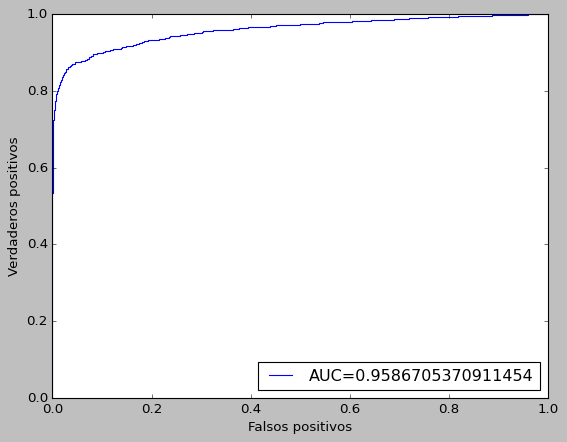

In [ ]:
y_pred_proba = model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
plt.legend(loc=4)
plt.show()

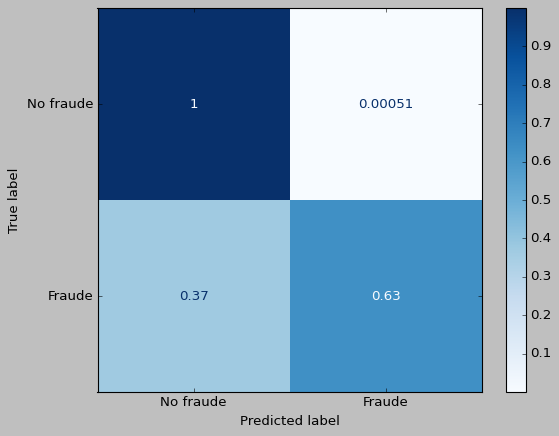

In [ ]:
plot_confusion_matrix(model1, X_test, y_test, display_labels=['No fraude',
                                                          'Fraude'],
                     normalize='true', cmap='Blues');

In [15]:
# save model to file
pickle.dump(model1, open("gbm_n005.pickle.dat", "wb"))

As a final observation, although both the XGBoost and GradientBoosting models perform well with respect to the AUC_ROC metric, the correlation matrix shows that in both cases there is a certain percentage of misclassification of our label of interest (Fraud), with 29.0% and 37.0% false negatives respectively. 